# Question 2: conditional variance as an approximation of mutual information

In [1]:
from scipy.stats import beta

In [2]:
# The code here is just for you to see how to call the entropy function.
a = 1
b = 10
conditional_entropy = beta.mean(a, b) * beta.entropy(a + 1, b) + (1 - beta.mean(a, b)) * beta.entropy(a, b + 1)
mutual_information = beta.entropy(a, b) - conditional_entropy
mutual_information

0.038366256079300776

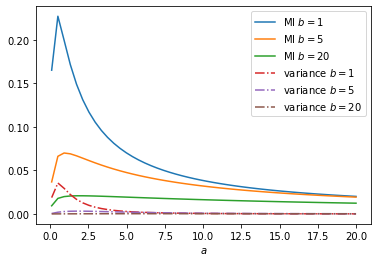

In [19]:
def comp_mi(al, be):
    conditional_entropy = beta.mean(al, be) * beta.entropy(al + 1, be) + (1 - beta.mean(al, be)) * beta.entropy(al, be + 1)
    return beta.entropy(al, be) - conditional_entropy

def comp_var(al, be):
    # closed-form solution computed using law of total expectation
    return 1 / (al + be + 1) ** 2. * (al * be / (al + be) ** 2.)

import numpy as np
import matplotlib.pyplot as plt

alphs = np.linspace(start=0.1, stop=20)

b1 = [comp_mi(alph, 1) for alph in alphs]
b5 = [comp_mi(alph, 5) for alph in alphs]
b20 = [comp_mi(alph, 20) for alph in alphs]
plt.plot(alphs, b1, label="MI $b=1$")
plt.plot(alphs, b5, label="MI $b=5$")
plt.plot(alphs, b20, label="MI $b=20$")

b1 = [comp_var(alph, 1) for alph in alphs]
b5 = [comp_var(alph, 5) for alph in alphs]
b20 = [comp_var(alph, 20) for alph in alphs]
plt.plot(alphs, b1, label="variance $b=1$", linestyle='-.')
plt.plot(alphs, b5, label="variance $b=5$", linestyle='-.')
plt.plot(alphs, b20, label="variance $b=20$", linestyle='-.')

plt.xlabel("$a$")
plt.legend()
plt.show()

# Question 3: Expected cumulative regret of Thompson sampling in the meeting room environment

You should not implement the Thompson sampling agent here. Compute the regret analytically. Optionally you can plot the analytically computed cumulative regret here.

# Question 4: Multi-item recommendation problem with per item cost

## Install and load the necessary packages

In [20]:
!pip install -q optax

In [21]:
import optax
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import plotnine as gg
import random
import scipy
from scipy import stats
from typing import Sequence

import matplotlib.pyplot as plt
import pylab
from sklearn.linear_model import LogisticRegression
from sympy.utilities.iterables import multiset_permutations

colors = {0: 'b',
          1: 'g',
          2: 'r',
          3: 'c',
          4: 'm',
          5: 'y'}

RuntimeError: This version of jaxlib was built using AVX instructions, which your CPU and/or operating system do not support. You may be able work around this issue by building jaxlib from source.

## Multi-item recommendation Environment

A multi-item reccomendation environment 

In [ ]:
class MultiItemRecommendationEnv(object):
  """Environment representing a multi-item recommendation environment."""

  def __init__(self, num_item, num_slot, sigma_p=1.0):
    self._num_item = num_item  # Total number of items that can be recommended
    self._num_slot = num_slot  # Number of available sltos
    self._sigma_p = sigma_p
    self._rng = np.random.default_rng()
    self.reset()

  def reset(self, seed: int=None):
    self._rng = np.random.default_rng(seed)
    # reset the environment - will generate a new environment
    self._theta = np.minimum(
        self._rng.normal(size=self._num_item) * self._sigma_p - 1.0 * self._sigma_p,
        0.0)

  def _validate_action(self, action):
    action = np.array(action)
    assert len(action) == self._num_item, f'action has wrong dimension {len(action)}.'
    return action

  def step(self, action: Sequence[int]):
    # select items to display based on the action
    action = self._validate_action(action)
    probs = self.compute_selection_probs(action)
    return self._rng.choice(self._num_item + 1, p=probs)

  def compute_selection_probs(self, action):
    action = self._validate_action(action)
    logits = self._theta * action
    logits[action <= 0.0] = -np.inf  # Set the logit for non selected item to -Inf
    logits = np.insert(logits, 0, 0.0)  # Add logits for the no-item-selected observation
    probs = np.exp(logits) / np.sum(np.exp(logits))
    return probs
    


## Agent for multi-item recommendation

### Optimization procedure

In [ ]:

def one_hot(indices, num_items: int):
  """Returns a one-hot encoding with shape [num_items+1, arr.size].
  """
  indices = np.array(indices)
  assert np.max(indices) <= num_items, "Input indices overflow."
  return np.eye(num_items+1)[indices].T


class MLR(object):
  """Multinomial Logistic Regression.
  
  Internal variables:
  _num_items: the number of items 
  _stepsize: the fixed constant stepsize in Newton's method
  _num_samples: the number of data samples.
  _action_history: np.ndarray with shape [_num_items, _num_samples], a binary
      matrix containing the set of items presented to the user in each data 
      sample.  The first row of _action_history is always all-zero.
  _observation_history: np.ndarray with shape [_num_items, _num_samples], each 
      column is a one-hot vector representing the item chosen by the user.  The
      zeroth item is the empty item.
  _sigma_p_squared: the regularization hyperparameter.
  _theta: the current parameters.
  """

  def __init__(
      self,
      num_items: int, # total number of items to display to customer 
      sigma_p_squared: float = 1.0,
      stepsize: float = 0.75,
  ):
    self._num_items = num_items 
    self._stepsize = stepsize
    self._num_samples = 0
    self._action_history = np.zeros((self._num_items+1, 0))
    self._observation_history = np.zeros((self._num_items+1, 0)) 
    self._sigma_p_squared = sigma_p_squared
    self._theta = np.zeros((self._num_items,))

    # An all-zero vector is added to the first column of item_embeddings to 
    # represent the zero (empty) item.
    self._item_embeddings = np.concatenate(
        (np.zeros((num_items, 1)), np.eye(num_items)), axis=1)

  @property 
  def coef_(self):
    return self._theta
  
  @property 
  def stepsize(self):
    return self._stepsize
  
  @stepsize.setter
  def stepsize(self, new_stepsize: float):
    self._stepsize = new_stepsize 

  def value_gradient_hessian(self):

    # probabilities
    exp_item_logits = np.exp(np.dot(self._item_embeddings.T, self._theta))
    prob = np.expand_dims(exp_item_logits, axis=1) * self._action_history
    prob /= np.sum(prob, axis=0, keepdims=True)

    # value
    value = 0.5 / self._sigma_p_squared * np.sum(np.square(self._theta))
    item_logits = np.dot(self._item_embeddings.T, self._theta)
    value -= np.sum(np.dot(self._observation_history.T, item_logits))
    value += np.sum(np.log(np.dot(exp_item_logits,
                                  self._action_history)))

    # gradient of log-likelihood
    grad = self._theta / self._sigma_p_squared
    grad -= np.sum(np.dot(self._item_embeddings, self._observation_history), axis=-1)
    grad += np.sum(np.dot(self._item_embeddings, prob), axis=-1)
    
    # hessian of log-likelihood
    hess = np.eye(self._num_items) / self._sigma_p_squared
    prob_feat = np.dot(self._item_embeddings, prob)
    hess -= np.dot(prob_feat, prob_feat.T) 
    feat_prob_feat = np.expand_dims(self._item_embeddings, axis=-1
                                    ) * np.expand_dims(prob, axis=0)
    feat_prob_feat = np.tensordot(feat_prob_feat, self._item_embeddings, [[1], [1]])
    hess += np.sum(feat_prob_feat, axis=1)
    return value, grad, hess

  def fit(self, actions=None, observations=None, num_newton_steps=10, verbose=False):
    if actions is not None:
      num_new_samples = actions.shape[1]
      actions = np.r_[np.ones((1, num_new_samples)), actions]
      self._action_history = actions
    if observations is not None:
      self._observation_history = one_hot(observations, self._num_items)
    for _ in range(num_newton_steps):
      loss, grad, hess = self.value_gradient_hessian()
      self._theta -= self._stepsize * np.dot(np.linalg.inv(hess), grad)
      if verbose:
        print('loss:', loss, 'grad:', grad, 'hessian:', hess)
    return self._theta

### Helpful functions (**You need to change the code over here**)

In [ ]:
# Constructing an agent which can learn only from the reward or from all the observations

def choose_optimal_assortment_for_num_slots(theta, num_slot, rng=None):
  if rng is None:
    rng = np.random.default_rng()
  num_item = len(theta)
  theta_sorted_idx = np.argsort(-theta)
  theta_thr = theta[theta_sorted_idx[num_slot - 1]]
  theta_thr_idx = np.nonzero(theta == theta_thr)[0]
  theta_opt_idx = np.setdiff1d(theta_sorted_idx[:num_slot], theta_thr_idx, True)
  theta_opt_idx = np.concatenate((
      theta_opt_idx,
      rng.choice(theta_thr_idx, size=num_slot - len(theta_opt_idx), replace=False)))
  selected_items = np.zeros(num_item)
  selected_items[theta_opt_idx] = 1
  return selected_items

def select_opt_num_slots(theta, max_num_slot, cost_per_slot):
  ############### Start of Code Modification ################################
  ### Please implement to choose the optimal number of slots here
  ###########################################################################

  optimal_num_slots = ...
  return optimal_num_slots
  
  ################### End of Code Modification ##############################

def choose_optimal_assortment(theta, max_num_slot, rng=None, cost_per_slot:float=0):
  opt_num_slots = select_opt_num_slots(theta, max_num_slot, cost_per_slot)
  return choose_optimal_assortment_for_num_slots(theta, opt_num_slots, rng)



### Laplace agent which learns from observations

In [ ]:
'''
This function computes the inverse Hessian matrix of the loss function
theta.shape = (dim)
X.shape = (num_samples, dim)
'''
def get_hessian(theta, X, sigma_p_squared):

  H = np.eye(len(theta))/sigma_p_squared

  if X.shape[0] > 0:
    logits = np.dot(X, theta)
    tmp = np.exp(logits); y_pred = np.divide(tmp, 1+tmp)
    D = np.expand_dims(np.multiply(y_pred, 1-y_pred), axis=-1)
    H += X.T @ (D * X)

  return H



class LaplaceAgentLearnFromObs:
  """Agent based on Laplace approximation."""

  def __init__(self, num_item: int, num_slot: int, sigma_p_squared: float,
               cost_per_slot: float,
               ):
    self._num_item = num_item  # Total number of items that can be recommended
    self._num_slot = num_slot  # Number of available sltos
    self._sigma_p_squared = sigma_p_squared
    self._num_obs_category = num_item + 1
    self._cost_per_slot = cost_per_slot
    self.reward_fn = lambda obs, act: float(obs > 0.0) - self._cost_per_slot*np.sum(act)
    self.reset()

   
  def reset(self, seed:int = None):
    self._theta_mu = np.zeros(self._num_item)
    self._theta_sigma = None  
    self._initialization_phase = True
    self._action_history = np.array([])
    self._observation_history = np.array([])


    self._rng = np.random.default_rng(seed)
    self._solver = MLR(num_items=self._num_item,
                        sigma_p_squared=self._sigma_p_squared)
 
  def select_action(self, verbose=False):
    """Select an action."""
     # if in the initialization phase, choose a random action
    if self._initialization_phase:
      canonical_action = np.concatenate((
          np.ones(self._num_slot), np.zeros(self._num_item - self._num_slot)))
      action = self._rng.permutation(canonical_action)
    else:
      theta = self._sample_theta()
      # choose action based on sampled theta
      action = choose_optimal_assortment(theta, self._num_slot, self._rng,
                                         self._cost_per_slot)

    if verbose and (t+1)%100==0:
      print(f"Laplace Agent: selected action {action}")

    # check if we have observations with all possible obesrvations
    if (self._initialization_phase and
        len(np.unique(self._observation_history)) >= self._num_item + 1):
       self._initialization_phase = False

    return action

  def _sample_theta(self):
    assert self._theta_mu is not None and self._theta_sigma is not None
    theta = self._rng.multivariate_normal(
        self._theta_mu,
        self._theta_sigma,
        tol=1e-5)
    return theta

  def update(self, action: np.array, observation: int):
    if not (self._action_history.size > 0 and self._observation_history.size > 0):
      self._action_history = np.expand_dims(action, axis=0)
      self._observation_history = np.expand_dims(observation, axis=0)
    else:
      self._action_history = np.concatenate((self._action_history, action[None, ...]), axis=0)
      self._observation_history = np.concatenate((self._observation_history, [observation]), axis=0)
    if not self._initialization_phase:

      self._theta_mu = self._solver.fit(self._action_history.T, self._observation_history.T)
      # compute the inverse Hessian matrix
      _, _, hess = self._solver.value_gradient_hessian()
      self._theta_sigma = np.linalg.inv(hess + 1e-5 * np.eye(hess.shape[0]))


## Experiment class 

This helps us to conduct experiments 

In [ ]:
def plot_regret(result, timestep_res=50):
  cols = ['reward', 'regret', 'cumulative_regret']
  df_grp = result.groupby('step')[cols]
  df = pd.concat([
      df_grp.mean().rename(lambda c: c + '_mean', axis=1),
      df_grp.sem().rename(lambda c: c + '_sem', axis=1)],
      axis=1).reset_index()
  for c in cols:
    df[c + '_lbdd'] = df[c + '_mean'] - 2 * df[c + '_sem']
    df[c + '_ubdd'] = df[c + '_mean'] + 2 * df[c + '_sem']

  p = (
      gg.ggplot(df[df.step % timestep_res == 0],
                gg.aes(x='step', y='cumulative_regret_mean'))
      + gg.geom_line()
      + gg.geom_errorbar(gg.aes(ymin='cumulative_regret_lbdd',
                                ymax='cumulative_regret_ubdd'))
      + gg.xlab('Time')
      + gg.ylab('Cumulative regret')
  )
  return p

class Experiment(object):

  def __init__(self, agent, environment):
    """
    Args:
      agent: The agent to train and evaluate.
      environment: The environment to train on.
    """
    self._agent = agent
    self._env = environment
    # self._contextual = contextual 
    self._result_df = None

  def run(self, seeds: Sequence[int], time_horizon: int, verbose: bool = True) -> None:
    """Runs an agent on an environment.
    Args:
      time_horizon: Number of steps in each trial.
      num_simulation: Number of simulations to run.
      verbose: Whether to also log to terminal.
    """

    results = []
    for sidx, seed in enumerate(seeds):
      print(f'Running simulation {sidx}')
      self._env.reset(seed)
      self._agent.reset(seed)
      cumulative_regret = 0.

      action = choose_optimal_assortment(self._env._theta, self._agent._num_slot,
                                         self._agent._rng, self._agent._cost_per_slot)
      optimal_reward = max(1.0 - self._env.compute_selection_probs(action)[0] \
                           - self._agent._cost_per_slot*np.sum(action), 0)

      for tidx in range(time_horizon):
        # Generate an action from the agent's policy.
      
        action = self._agent.select_action()
        update_args = ()
        # Step the environment.
        obs = self._env.step(action)
        expected_reward = max(1.0 - self._env.compute_selection_probs(action)[0] \
                              - self._agent._cost_per_slot*np.sum(action), 0)
        reward = self._agent.reward_fn(obs, action)
        # Update the agent
        update_args += (action, obs)
        self._agent.update(*update_args)
  
        # Book keeping
        regret = optimal_reward - expected_reward
        cumulative_regret += regret
        if verbose and tidx % 100 == 0:
          regret_stats = {
              'instance regret': regret, 
              'cumulative': cumulative_regret,
              'per_step regret': cumulative_regret / (tidx + 1)}
          print(f'regret at step {tidx}: {regret_stats}')
  
        results.append((sidx, tidx, reward, regret, cumulative_regret))
    self._result = pd.DataFrame(
        results, 
        columns=['trial', 'step', 'reward', 'regret', 'cumulative_regret'])
    return self._result

## Running the experiment 

In [ ]:
num_item = 10
sigma_p_squared = 1.0 
num_slot = 5

num_simulations = 5
horizon = 1001

In [ ]:
plt.figure(num_slot)
plt.clf()

for cost_per_slot in [0.02, 0.1]:
  learn_from_reward = False
  print('running simulation for number of slots = '+str(num_slot) 
                        + ' cost per slot = '+str(cost_per_slot))
  env = MultiItemRecommendationEnv(num_item, num_slot, sigma_p=np.sqrt(sigma_p_squared))
  agent = LaplaceAgentLearnFromObs(num_item, num_slot, sigma_p_squared,
                       cost_per_slot=cost_per_slot,
                       )
  experiment = Experiment(agent, env)
  result_obs = experiment.run(range(num_simulations), horizon, verbose=False)
  plot_regret(result_obs, timestep_res=50)

  res_obs_summary = result_obs.groupby('step').mean()
  # colors = ['r', 'g', 'b']

  plt.plot(res_obs_summary.index, res_obs_summary.cumulative_regret, # color=colors[1],\
          linestyle='-', linewidth=2, \
          label=f'learning from observation cost per slot: '+str(cost_per_slot))

plt.legend(loc="best", fontsize=9)
plt.xlabel("$t$", fontsize=14)
plt.ylabel("cumulative regret", fontsize=14)
plt.title(f'N={num_item}, K={num_slot}')

# Question 5: Alternatives to maximizing information gain from practice exam

## Environment

In [ ]:
import jax
import numpy as np
import pandas as pd
import plotnine as gg
import random
import scipy
from scipy import stats
import time
from typing import Callable, Sequence

import matplotlib.pyplot as plt
import pylab
from sklearn.linear_model import LogisticRegression

from google.colab import files

colors = {0: 'b',
          1: 'g',
          2: 'r',
          3: 'c',
          4: 'm',
          5: 'y'}

In [ ]:
class MultipleLogisticEnv(object):
  """Environment representing a logistic model with multiple concurrent binary outputs."""

  def __init__(self, action_feature_dim: int, embedding_dim: int, output_dim: int, num_action: int, sigma_p: float = 1.0):
    self._action_feature_dim = action_feature_dim
    self._embedding_dim = embedding_dim
    self._output_dim = output_dim
    self._num_action = num_action
    self._sigma_p = sigma_p
    self._theta = None
    self.output_features = None 
    self.action_features = None 

  def reset(self, seed: int):
    self._rng = np.random.default_rng(seed)
    self._theta = self._sigma_p * self._rng.normal(size=(self._action_feature_dim - 1, self._embedding_dim))
    self._theta = np.r_[self._theta, -np.ones((1, self._embedding_dim))]
    self.output_features = np.abs(self._rng.normal(size=(self._embedding_dim, self._output_dim)))
    self.action_features = self._rng.normal(size=(self._action_feature_dim - 1, self._num_action))
    self.action_features /= np.linalg.norm(self.action_features, axis=0, keepdims=True)
    self.action_features = np.r_[self.action_features, np.ones((1, self._num_action))]

  def _validate_action(self, action):
    curriculum_idx, practice_idx = action
    assert 0 <= curriculum_idx and curriculum_idx < self._num_action
    assert 1 <= practice_idx and practice_idx < self._output_dim, 'practice_idx:{}'.format(practice_idx)# practice idx cannot be 0 since that is the official exam.
    assert self.action_features is not None, 'Please first reset the environment.'
    return curriculum_idx, practice_idx

  def step(self, action: np.ndarray):
    probs = self.compute_output_probs(action)
    return (self._rng.random(len(probs)) <= probs).astype(np.float32)

  def compute_output_probs(self, action):
    curriculum_idx, practice_idx = self._validate_action(action)
    action_feature = self.action_features[:, curriculum_idx]
    embedding = action_feature.T @ self._theta
    logits = embedding @ self.output_features[:, [0, practice_idx]]
    exp_logits = np.exp(logits)
    probs = exp_logits / (1 + exp_logits)
    return probs


##Agent

### Some utilities for the agent

In [ ]:
'''
This function computes the Hessian matrix of the loss function
theta.shape = (dim)
X.shape = (num_samples, dim)
'''
def get_hessian(theta, X, sigma_p_squared):

  H = np.eye(len(theta))/sigma_p_squared

  if X.shape[0] > 0:
    logits = np.dot(X, theta)
    tmp = np.exp(logits); y_pred = np.divide(tmp, 1+tmp)
    D = np.expand_dims(np.multiply(y_pred, 1-y_pred), axis=-1)
    H += X.T @ (D * X)

  return H


def get_inv_hessian(theta, X, sigma_p_squared):

  H = get_hessian(theta, X, sigma_p_squared)
  return np.linalg.inv(H)


def choose_optimal_action(rng: np.random.Generator, scores: np.ndarray):
  assert scores.ndim == 1, 'scores should be 1D array.'
  # choose action based on sampled theta
  num_action = len(scores)
  optimal_actions = np.arange(num_action)[scores == scores.max()]
  action = rng.choice(optimal_actions)
  return action
 
def get_expected_regret(rng, theta_mu, theta_sigma, action_features_reward):
  theta = rng.multivariate_normal(
      theta_mu,
      theta_sigma,
      size=10,
      tol=1e-5).T
  exp_logits = np.exp(action_features_reward.T @ theta)  # shape=(num_action, num_smaple)
  probs = exp_logits / (1.0 + exp_logits)
  regrets = probs.max(axis=0, keepdims=True) - probs
  return regrets.mean(axis=1)


### Agent based on Laplace Approximation

In [ ]:
class LaplaceAgent:
  """Agent based on Laplace approximation."""

  def __init__(self, action_selection_fn: Callable, sigma_p_squared: float):
               # learn_from_reward: bool = True):
    self._action_selection_fn = action_selection_fn
    self._sigma_p_squared = sigma_p_squared

  def reset(self, seed, action_features: np.ndarray, output_features: np.ndarray):
    self._rng = np.random.default_rng(seed)
    self._embedding_dim, self._output_dim = output_features.shape
    self._action_features_raw = action_features
    self._action_feature_dim_raw, self._num_action = action_features.shape
    self._action_feature_dim = self._action_feature_dim_raw * self._embedding_dim
    self._output_features = output_features

    self._action_features = np.stack([
        np.kron(np.eye(self._embedding_dim), self._action_features_raw[:, idx]).T @ self._output_features
        for idx in range(self._num_action)], axis=-1)
    assert self._action_features.shape == (
        self._action_feature_dim,
        self._output_dim,
        self._num_action)

    self._theta_mu = np.zeros(self._action_feature_dim)
    self._initialization_phase = True
    self._action_feature_history = np.array([])
    self._observation_history = np.array([])

    self._solver = LogisticRegression(penalty='l2', 
                                      C=2*self._sigma_p_squared,
                                      fit_intercept=False,
                                      warm_start=True,
                                      max_iter=500)
 
  @property
  def action_features(self):
    return self._action_features_raw
    
  @property
  def theta_mean_covar(self):
    theta_sigma = get_inv_hessian(self._theta_mu, self._action_feature_history, self._sigma_p_squared)
    return self._theta_mu, theta_sigma

  def select_action(self, verbose=False):
    """Select an action."""
     # if in the initialization phase, choose a random action
    if self._initialization_phase:
      curriculum_idx = self._rng.integers(self._num_action)
      practice_idx = self._rng.integers(1, self._output_dim)
      action = curriculum_idx, practice_idx
    else:
      action = self._action_selection_fn(
          self._rng,
          self._theta_mu,
          self._action_features,
          self._action_feature_history,
          self._sigma_p_squared,
          self._output_features)
      
    if verbose and (t+1)%100==0:
      print(f"Laplace Agent: selected action {action}")

    # check if we have observations with all possible obesrvations
    if self._initialization_phase and self._observation_history.size > 0:
      if len(np.unique(self._observation_history)) >= 2:
        self._initialization_phase = False

    return action

  def update(self, action: np.array, observation: int):
    curriculum_idx, practice_idx = action
    action_feature = self._action_features[:, [0, practice_idx], curriculum_idx].T
    if not (self._action_feature_history.size > 0 and self._observation_history.size > 0):
      self._action_feature_history = action_feature
      self._observation_history = np.expand_dims(observation, axis=0)
    else:
      self._action_feature_history = np.concatenate(
          # action_feature already has a batch dim.
          (self._action_feature_history, action_feature), axis=0)
      self._observation_history = np.concatenate(
          (self._observation_history, observation[None, ...]), axis=0)
    if not self._initialization_phase:
      targets = self._observation_history.flatten()  # flatten is row-major by default.

      self._solver.fit(self._action_feature_history, targets)
      self._theta_mu = np.squeeze(self._solver.coef_)



In [ ]:
def ts_action_selection(
    rng: np.random.Generator,
    theta_mu: np.ndarray,
    action_features: np.ndarray,
    action_feature_history: np.ndarray,
    sigma_p_squared: float,
    output_features: np.ndarray = None):
  num_practice = action_features.shape[1] - 1
  theta_sigma = get_inv_hessian(theta_mu, action_feature_history, sigma_p_squared)
  assert theta_mu is not None
  theta = rng.multivariate_normal(
      theta_mu,
      theta_sigma,
      tol=1e-5)
  # choose action based on sampled theta
  logits = action_features[:, 0, :].T @ theta
  curriculum_idx = choose_optimal_action(rng, logits)
  practice_idx = rng.integers(1, num_practice)
  return curriculum_idx, practice_idx 

def get_diff_entropy(hessian: np.ndarray):
  """Computes the expected entropy given theta and negative log posterior hessian."""
  ld_sign, log_det_hessian = np.linalg.slogdet(hessian)
  assert ld_sign >= 0, 'Hessian is not positive semidefinite.'
  n = hessian.shape[0]
  dentropy = 0.5 * (n * np.log(2 * np.pi * np.e) - log_det_hessian)
  return dentropy

def get_entropy_reduction(theta_mu, action_features, action_feature_history, sigma_p_squared):
    num_action = action_features.shape[-1]
    hessian = get_hessian(theta_mu, action_feature_history, sigma_p_squared)
    diff_entropy = get_diff_entropy(hessian)
    hessian_tp1 = [get_hessian(
        theta_mu,
        np.r_[action_feature_history, action_features.T[[aidx], :]],
        sigma_p_squared)
        for aidx in range(num_action)]
    diff_entropy_tp1 = np.array([get_diff_entropy(h) for h in hessian_tp1])
    entropy_reduction = diff_entropy - diff_entropy_tp1
    return entropy_reduction


def tswis_action_selection(
    rng: np.random.Generator,
    theta_mu: np.ndarray,
    action_features: np.ndarray,
    action_feature_history: np.ndarray,
    sigma_p_squared: float,
    output_features: np.ndarray):
  """Thompsong sampling with information seeking for the practice exam."""
  
  # Select the curriculum first based on optimal choice for the exam.
  curriculum_idx, _ = ts_action_selection(
    rng,
    theta_mu,
    action_features,
    action_feature_history,
    sigma_p_squared)
    
  # Then select practice exam wich maximizes information gain given curriculum_idx
  assert theta_mu is not None
  action_features_practice = action_features[:, 1:, curriculum_idx]
  entropy_reductions = get_entropy_reduction(
      theta_mu, action_features_practice, action_feature_history, sigma_p_squared) 
  practice_idx = choose_optimal_action(rng, entropy_reductions) + 1 
  return curriculum_idx, practice_idx


## PLEASE READ

recall from lecture 8 that we introduced a linear form for the observation probability $$\Pr[O_{t+1, m} = 1| H_t, A_t, \mathcal{E}] = {\tt logistic} (\psi_m^\top (I \otimes \phi_{a_t}) {\tt vec}(\theta))$$. In the part of the code that you will be modifying we already did this transformation for you. 

1. `theta` in this part represents the vectorized for of ${\tt vec}(\theta)$. 
Hence `len(theta)` is equal to number of subjects * curriculum dimension, i.e., $K*d$. `theta_mu` is the estimated mean of this vectorized theta, and `theta_sigma` is the estimated covariance of the vectorized theta.
2. `output_features` represents the concatenation of official exam feature and practice exam features $[\psi_0, \psi_{1:M}]$. Hence its shape is (number of subjects, number of practice exams + 1), i.e., $(K, M+1)$.
3. `action_features` represents the concatenation of the transformed curricula features $\psi_m^\top (I \otimes \phi_{a}) {\tt vec}(\theta)$ along two axes corresponding to $m$ and $a$. Hence, it's shape is (number of subjects * curriculum dimension, number of practice exams +1, number of curricula), i.e., $(K*d, M+1, N)$.

Note that in our notation all vectors are assumed column vector.

In this form `action_features[:, m, a].T @ theta` represents $\psi_m^\top (I \otimes \phi_{a}) {\tt vec}(\theta)$ which can be used compute $$\Pr[O_{t+1, m} = 1| H_t, A_t, \mathcal{E}] = {\tt logistic} (\psi_m^\top (I \otimes \phi_{a_t}) {\tt vec}(\theta))$$

###Thompson sampling with expected practice exam score maximization (**add your code here**)

In [ ]:
def ts_with_practice_score_maximization(
    rng: np.random.Generator,
    theta_mu: np.ndarray,
    action_features: np.ndarray,
    action_feature_history: np.ndarray,
    sigma_p_squared: float,
    output_features: np.ndarray):
  """Thompsong sampling withaction_features practice exam score maximization."""
  
  # Select the curriculum first based on optimal choice for the exam.
  theta_sigma = get_inv_hessian(theta_mu, action_feature_history, sigma_p_squared)
  assert theta_mu is not None
  theta = rng.multivariate_normal(
      theta_mu,
      theta_sigma,
      tol=1e-5)
  # choose action based on sampled theta
  logits = action_features[:, 0, :].T @ theta
  curriculum_idx = choose_optimal_action(rng, logits)  
  # Then select practice wich maximizes expected practice exam score given curriculum_idx
  action_features_practice = action_features[:, 1:, curriculum_idx]
  # Note that practice exams features start from index 1 (official exam is index 0).
 
  ############### Start of Code Modification ################################
  ### Please implement practice exam selection that chooses exam with highest
  ### expected score.
  ###########################################################################

  practice_idx = ...
  ################### End of Code Modification ##############################
  
  return curriculum_idx, practice_idx


###Thompson sampling with practice exam similarity maximization (**add your code here**)

In [ ]:
def ts_with_practice_similarity_maximization(
    rng: np.random.Generator,
    theta_mu: np.ndarray,
    action_features: np.ndarray,
    action_feature_history: np.ndarray,
    sigma_p_squared: float,
    output_features: np.ndarray):
  """Thompsong sampling with practice exam similarity maximization."""
  
  # Select the curriculum first based on optimal choice for the exam.
  curriculum_idx, _ = ts_action_selection(
    rng,
    theta_mu,
    action_features,
    action_feature_history,
    sigma_p_squared)
    
  # Then select practice exam wich maximizes exams' feature similarity given curriculum_idx
  assert theta_mu is not None
  output_features_practice = output_features[:, 1:] # psi's for practice exam
  # Note that practice exams features start from index 1 (official exam is index 0).
 
  ############### Start of Code Modification ################################
  ### Please implement practice exam selection that chooses exam with highest
  ### similarity to the official exam.
  ###########################################################################

  practice_idx = ...
  ################### End of Code Modification ##############################
  
  return curriculum_idx, practice_idx


### Thompson sampling with practice exam logit variance maximization (**add your code here**)

In [ ]:
def ts_with_practice_score_logit_var_maximization(
    rng: np.random.Generator,
    theta_mu: np.ndarray,
    action_features: np.ndarray,
    action_feature_history: np.ndarray,
    sigma_p_squared: float, 
    output_features: np.ndarray):
  """Thompsong sampling with variance of practice score logit maximization."""
  
  # Select the curriculum first based on optimal choice for the exam.
  curriculum_idx, _ = ts_action_selection(
    rng,
    theta_mu,
    action_features,
    action_feature_history,
    sigma_p_squared)
    
  # Then select practice wich maximizes the variance of the practice exam's logit given curriculum_idx
  assert theta_mu is not None
  theta_sigma = get_inv_hessian(theta_mu, action_feature_history, sigma_p_squared)
  action_features_practice = action_features[:, 1:, curriculum_idx]
  # Note that practice exams features start from index 1 (official exam is index 0).
 
  ############### Start of Code Modification ################################
  ### Please implement practice exam selection that chooses exam with highest
  ### estimated variance of the logit.
  ###########################################################################
  
  practice_idx = ...
  ################### End of Code Modification ##############################
  
  return curriculum_idx, practice_idx


## Experiment

In [ ]:
class Experiment(object):

  def __init__(self, agent, environment):
    """
    Args:
      agent: The agent to train and evaluate.
      environment: The environment to train on.
    """
    self._agent = agent
    self._env = environment
    self._result_df = None

  def run(self, seeds: Sequence[int], time_horizon: int, verbose: bool = True) -> None:
    """Runs an agent on an environment.
    Args:
      time_horizon: Number of steps in each trial.
      num_simulation: Number of simulations to run.
      verbose: Whether to also log to terminal.
    """

    results = []
    for sidx, seed in enumerate(seeds):
      print(f'Running simulation {sidx}')
      start_time = time.time()
      self._env.reset(seed)
      self._agent.reset(seed, self._env.action_features, self._env.output_features)
      cumulative_regret = 0.
      num_action = self._agent.action_features.shape[-1]
      expected_rewards = np.array([
          self._env.compute_output_probs((aidx, 1))[0] for aidx in range(num_action)])
      optimal_reward = expected_rewards.max()

      for tidx in range(time_horizon):
        # Generate an action from the agent's policy.
        action = self._agent.select_action()
        # Step the environment.
        obs = self._env.step(action)
        expected_reward = self._env.compute_output_probs(action)[0]
        reward = obs[0]
        # Update the agent
        self._agent.update(action, obs)
  
        # Book keeping
        regret = optimal_reward - expected_reward
        cumulative_regret += regret
        if verbose and tidx % 100 == 0:
          regret_stats = {
              'instance': regret, 
              'cumulative': cumulative_regret,
              'per_step': cumulative_regret / (tidx + 1)}
          print(f'regret at step {tidx}: {regret_stats}')
  
        results.append((sidx, tidx, reward, regret, cumulative_regret))
      print(f'experiment {sidx} took {time.time() - start_time} seconds.')

    self._result = pd.DataFrame(
        results, 
        columns=['trial', 'step', 'reward', 'regret', 'cumulative_regret'])
    return self._result

In [ ]:
action_feature_dim = 20  # Dimension of curricula
embedding_dim = 2  # Number of subjects
output_dim = 50  # Number of exams
num_action = 50
sigma_p_squared = 1

num_experiment = 5
horizon = 1001
seeds = range(num_experiment)

env = MultipleLogisticEnv(
    action_feature_dim=action_feature_dim,
    embedding_dim=embedding_dim,
    output_dim=output_dim,
    num_action=num_action,
    sigma_p=np.sqrt(sigma_p_squared))
 
def experiment_factory(action_selection_fn, env=env):
  agent = LaplaceAgent(
      action_selection_fn,
      sigma_p_squared=sigma_p_squared)
  return Experiment(agent, env)



In [ ]:
action_selection_fn = tswis_action_selection
experiment = experiment_factory(action_selection_fn)
result_tswis = experiment.run(seeds, horizon)

In [ ]:
action_selection_fn = ts_action_selection
experiment = experiment_factory(action_selection_fn)
result_ts = experiment.run(seeds, horizon)

In [ ]:
res_ts_summary = result_ts.groupby('step').mean()
res_tswis_summary = result_tswis.groupby('step').mean()

In [ ]:
plt.figure(1)
plt.clf()

plt.plot(res_ts_summary.index, res_ts_summary.cumulative_regret, color=colors[0],\
         linestyle='-', linewidth=2, label=f'TS')
plt.plot(res_tswis_summary.index, res_tswis_summary.cumulative_regret, color=colors[1],\
         linestyle='-', linewidth=2, label=f'TS with info seeking')

plt.legend(loc="best", fontsize=9)
plt.xlabel("$t$", fontsize=14)
plt.ylabel("cumulative regret", fontsize=14)
plt.title(f'N={action_feature_dim}, K={embedding_dim}, M={output_dim}')

# save the plot
filename_image = f'ai_tutor_cumulative_regret.pdf'
plt.savefig(filename_image)
files.download(filename_image)
plt.show()